In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

In [28]:
df = pd.read_csv("framingham.csv")
df.drop(['education'], axis=1, inplace=True)
df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [29]:
df.rename(columns={'male':'hombre'}, inplace=True)
df.isnull().sum()

hombre               0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [30]:
c=0
for i in df.isnull().sum(axis=1):
  if i>0:
    c=c+1
print('El número total de columnas con valores nulos es:', c,)
print('Como solo es', round((c/len(df.index))*100), 'porciento del dataframe, se excluirán del análisis.')

El número total de columnas con valores nulos es: 489
Como solo es 12 porciento del dataframe, se excluirán del análisis.


In [31]:
df.dropna(axis=0, inplace=True)

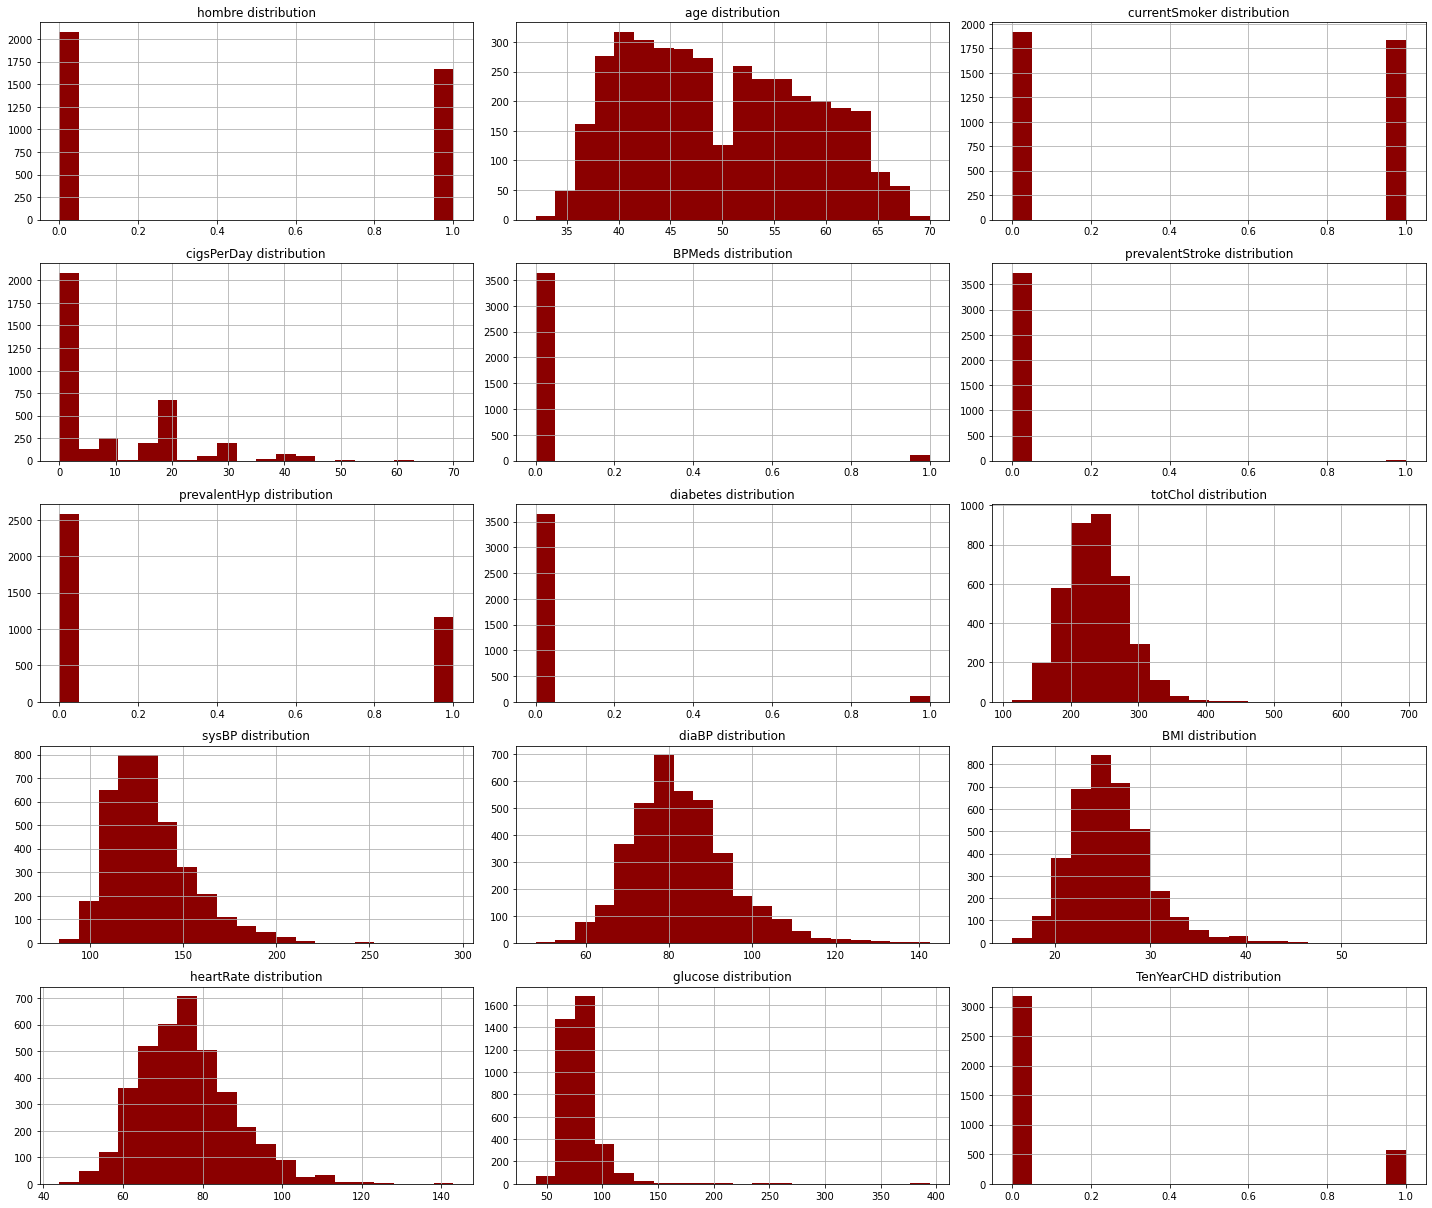

In [32]:
def plot_histograms(dataframe, features, rows, cols):
  fig = plt.figure(figsize=(20, 20))
  for i, feature in enumerate(features):
    ax = fig.add_subplot(rows, cols, i+1)
    dataframe[feature].hist(bins=20, ax=ax, facecolor='DarkRed')
    ax.set_title(feature+" distribution", color='Black')
  
  fig.tight_layout()
  plt.show()
plot_histograms(df, df.columns, 6,3)

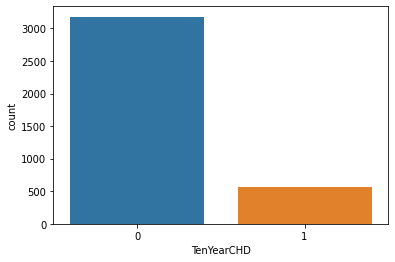

In [33]:
df.TenYearCHD.value_counts()
sns.countplot(x='TenYearCHD', data=df)

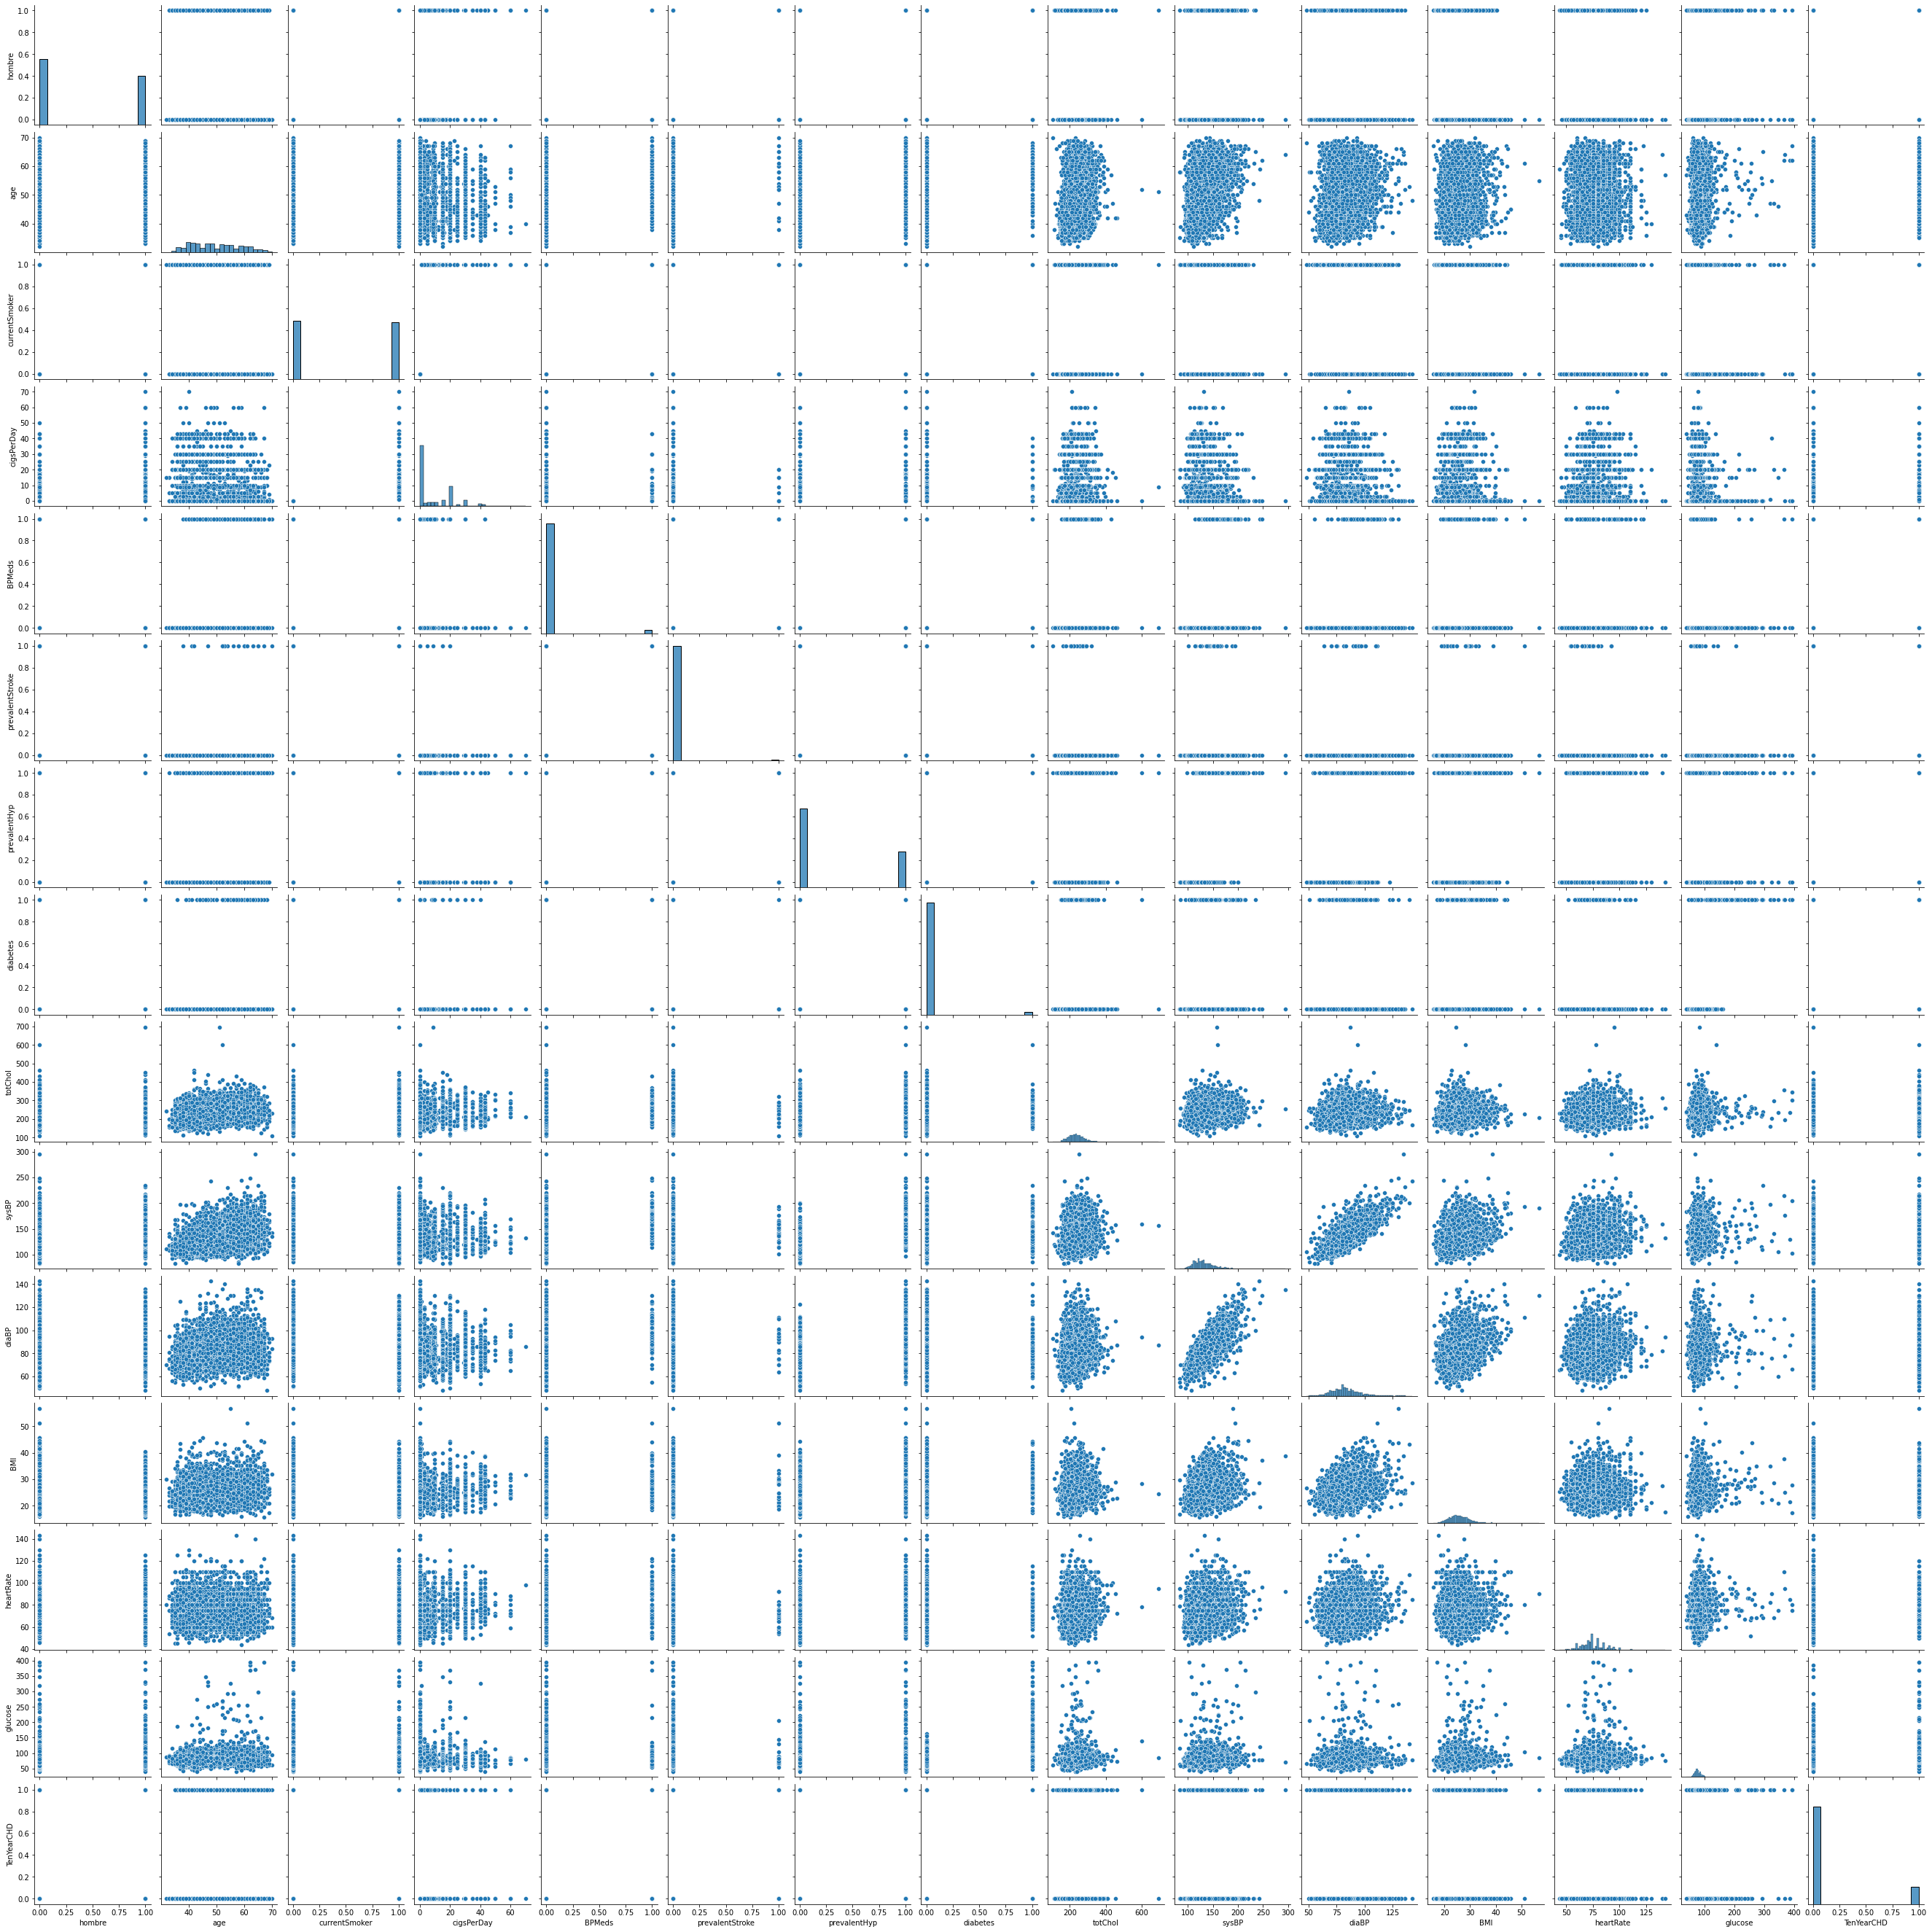

In [15]:
sns.pairplot(data=df)

In [34]:
df.describe()

,hombre,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [35]:
from statsmodels.tools import add_constant as add_constant
df_constant = add_constant(df)
df_constant.head()

,const,hombre,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [46]:
st.distributions.chi2.sf = lambda chisq, df: st.chi2.sf(chisq, df)
cols = df_constant.columns[:-1]
model = sm.Logit(df.TenYearCHD, df_constant[cols])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.377036
         Iterations 7


In [47]:
def back_feature_elem (data_frame, dep_var, col_list):
  while len(col_list)>0:
    model=sm.Logit(dep_var, data_frame[col_list])
    result = model.fit(disp=0)
    largest_pvalue = round(result.pvalues, 3).nlargest(1)
    if largest_pvalue[0]<(0.05):
      return result
      break
    else:
      col_list = col_list.drop(largest_pvalue.index)

result = back_feature_elem(df_constant, df.TenYearCHD, cols)

In [53]:
parameters = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = parameters
pvalue = round(result.pvalues, 3)
conf['pvalue'] = pvalue
conf.columns = ['IC 95%(2.5%)', 'IC 95%(97.5%)', 'Odds ratio', 'pvalue']
print((conf))

            IC 95%(2.5%)  IC 95%(97.5%)  Odds ratio  pvalue
const           0.000043       0.000272    0.000109   0.000
hombre          1.455242       2.198536    1.788687   0.000
age             1.054483       1.080969    1.067644   0.000
cigsPerDay      1.011733       1.028128    1.019897   0.000
totChol         1.000158       1.004394    1.002273   0.035
sysBP           1.013292       1.021784    1.017529   0.000
glucose         1.004346       1.010898    1.007617   0.000


In [92]:
import sklearn
new_features = df[['age', 'hombre', 'cigsPerDay', 'totChol', 'sysBP', 'glucose', 'TenYearCHD']]
x = new_features.iloc[:,:-1]
y = new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=5)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, pred)

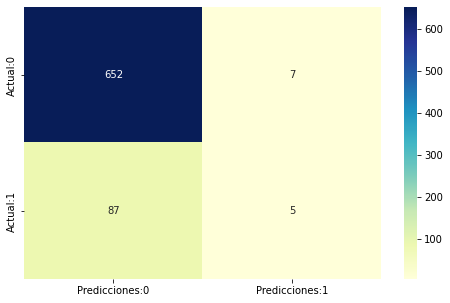

In [94]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test, pred)
conf_matrix = pd.DataFrame(data=confmat, columns = ['Predicciones:0', 'Predicciones:1'], index=['Actual:0', 'Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]
FP = confmat[0,1]
sensibilidad = TP/float(TP+FN)
especificidad = TN/float(TN+FP)

In [103]:
print('La precisión del modelo es del:', accuracy)
print('Los errores de clasificación son del:', 1-accuracy)
print('Sensibilidad:', sensibilidad)
print('Especificidad', especificidad)

La precisión del modelo es del: 0.8748335552596538
Los errores de clasificación son del: 0.12516644474034622
Sensibilidad: 0.05434782608695652
Especificidad 0.9893778452200304


In [105]:
pred_prob = logreg.predict_proba(x_test)[:,:]
pred_prob_df = pd.DataFrame(data=pred_prob, columns=['Prob de no enfermedad del corazón (0)','Prob de Enfermedad del Corazón (1)'])
pred_prob_df.head()

,Prob de no enfermedad del corazón (0),Prob de Enfermedad del Corazón (1)
0,0.875308,0.124692
1,0.956491,0.043509
2,0.783654,0.216346
3,0.806745,0.193255
4,0.893132,0.106868


In [118]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    cm2=0
    pred_prob_yes=logreg.predict_proba(x_test)
    pred2=binarize(pred_prob_yes)[:,1]
    cm2=confusion_matrix(y_test,pred2)

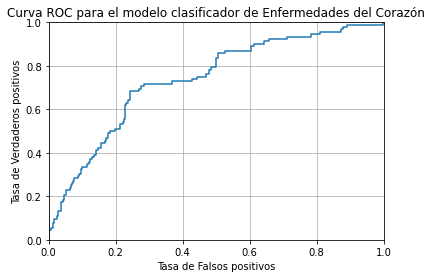

In [119]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para el modelo clasificador de Enfermedades del Corazón')
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.grid(True)